# Modeling 1: Baseline, Decision Tree, Random Forest

- **Author**: Dan O'Connor
- **Notebook**: 4 of 9

In this notebook I will establish a baseline model on multiple success metrics. In addition to accuracy, I will look into metrics that better explain how the model is performing with an imbalanced dataset such as f1-score, recall, and precision. I then will create baseline and optimized models for random forest and decision tree classifiers and store their success metrics in a dataframe.

## Table of Contents
[Baseline Model](#Baseline-Model)

[Decision Tree](#Decision-Tree)

[Random Forest](#Random-Forest)

Import required libraries. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive #done in google colab

Mounting to gdrive for work in colab.

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


Import the dataframe.

In [4]:
subset_model_df = pd.read_csv('Data/subset_model_df.csv')

The graphic belows shows the percentage of the dataset that each genre accounts for. Immediately, it is clear that this is an imbalanced dataset. I attempt to account for the imbalance in the training in notebook 8 (SMOTE). 

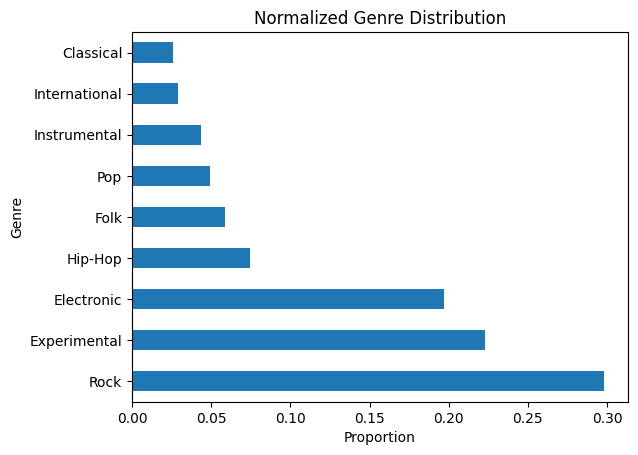

In [6]:
plt.figure()
subset_model_df['genre_top'].value_counts(normalize=True).plot(kind='barh')
plt.title('Normalized Genre Distribution')
plt.xlabel('Proportion')
plt.ylabel('Genre')
plt.show()

Here are the number of observations per class.

In [7]:
subset_model_df['genre_top'].value_counts()

Rock             14184
Experimental     10608
Electronic        9372
Hip-Hop           3552
Folk              2803
Pop               2332
Instrumental      2079
International     1389
Classical         1230
Name: genre_top, dtype: int64

## Baseline Model

In [42]:
#split into dep and indep. vars
X = subset_model_df.drop(columns='genre_top') 
y = subset_model_df['genre_top']
X.shape, y.shape

((47549, 350), (47549,))

In [43]:
from sklearn.preprocessing import LabelEncoder

# Encoder object
label_encoder = LabelEncoder()

# Fit the encoder on indep. var
label_encoder.fit(y)

#transform
y_encoded = label_encoder.transform(y)



Below shows how the label encoder works. It takes the genre label and converts it to an integer 0-8.

In [10]:
#create df with label encoded classes
class_df = pd.DataFrame({'class_label': label_encoder.classes_, 'encoded_value': range(len(label_encoder.classes_))})
class_df.set_index('encoded_value', inplace=True) #set index

y_encoded_df = pd.DataFrame({'y_encoded': y_encoded}) #new df with encoded labels
y_encoded_df.drop_duplicates(inplace=True) #drop duplicates

class_table = y_encoded_df.merge(class_df, how='left', left_on='y_encoded', right_index=True) #merge the two df
class_table = class_table.set_index('y_encoded').sort_index(ascending=True) #set index

class_table

,class_label
y_encoded,
0,Classical
1,Electronic
2,Experimental
3,Folk
4,Hip-Hop
5,Instrumental
6,International
7,Pop
8,Rock


The baseline accuracy can be thought of as guessing the majority class everytime. In this case, any model would be 29% accurate if it simply guessed rock for every observation. The other baseline metrics like f1, recall, and precision are not quite as simple to calculate because they take into account true positives, true negatives, false positives, and false negatives for each genre. I created a function `baseline` below that randomly guesses classes for the number of samples in the testing set based on the proportion of the genres. 

In [12]:

import random 
from sklearn.metrics import classification_report

recall_dict = {key: [] for key in set(y_test)}
f1_dict = {key: [] for key in set(y_test)}
precision_dict = {key: [] for key in set(y_test)}
weighted_f1 = []
weighted_recall = []
weighted_precision = []

def baseline(y,randomstate):
    genres = list(set(y)) # label encoded genres
    probabilities = np.bincount(y)/y.shape[0] #probabilties of each genre
    random.seed(randomstate) #random state
    y_pred = random.choices(genres, weights=probabilities,k=y.shape[0]) #an array of size y, with the weights being the prob
    class_report = classification_report(y,y_pred, output_dict=True) #To access elements of class report
    weighted_recall.append(class_report['weighted avg']['recall']) #add weighted recall
    weighted_precision.append(class_report['weighted avg']['precision']) #add weighted prec
    weighted_f1.append(class_report['weighted avg']['f1-score']) #add weighted f1
    for genre in list(set(y)): #cycle thru genres
        recall_dict[genre].append(class_report[str(genre)]['recall']) 
        precision_dict[genre].append(class_report[str(genre)]['precision'])
        f1_dict[genre].append(class_report[str(genre)]['f1-score'])
        
    return None

Below I ran the function `baseline` 1000 times to take the mean of the predicted metrics. I then take the mean of all the samples for my baseline. This approach is also a neat demonstration of central limit theorem, which states that as the sample size increases the variability of the sample means decrease and the distribution of the sample means become more normal. This is shown below for the f-1 scores per genre.

In [13]:
for i in range(1,1000):
    baseline(y_test,i)

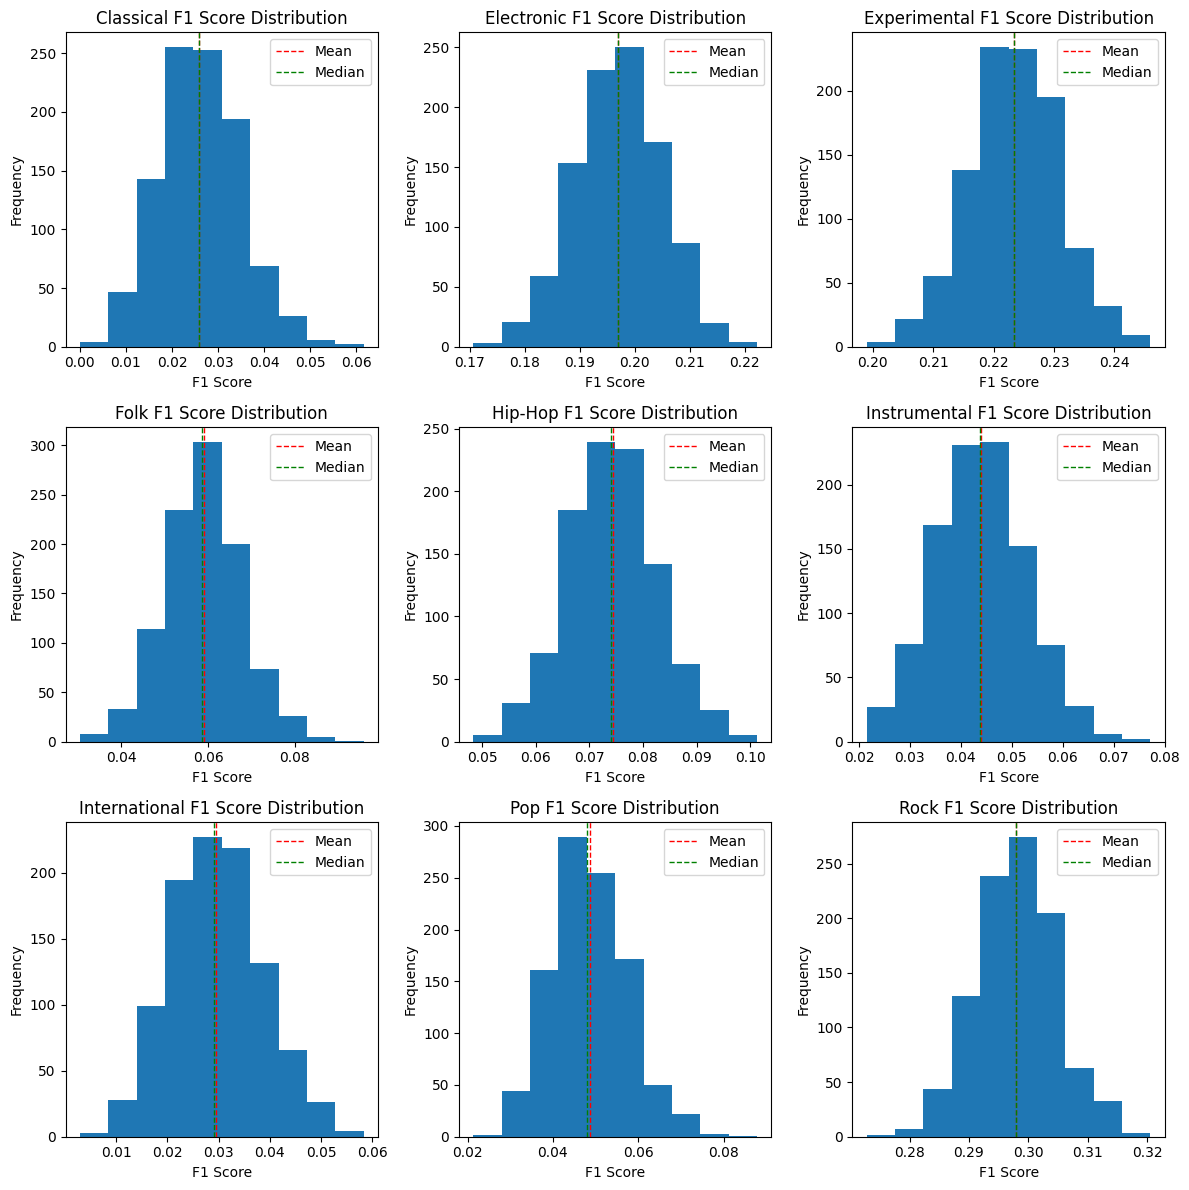

In [14]:
genre_names = {0: 'Classical', 1: 'Electronic', 2: 'Experimental', 3: 'Folk', 4: 'Hip-Hop',\ #genre dict
               5: 'Instrumental', 6: 'International', 7: 'Pop', 8: 'Rock'}

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12)) #3v3 grid
axs = axs.flatten()
# create subplotts
for i, genre in enumerate(f1_dict):
    axs[i].hist(f1_dict[genre])
    axs[i].set_title(f'{genre_names[genre]} F1 Score Distribution')
    axs[i].set_xlabel('F1 Score')
    axs[i].set_ylabel('Frequency')
    axs[i].axvline(np.mean(f1_dict[genre]), color='r', linestyle='dashed', linewidth=1, label='Mean')
    axs[i].axvline(np.median(f1_dict[genre]), color='g', linestyle='dashed', linewidth=1, label='Median')
    axs[i].legend()
    
plt.tight_layout()
plt.show()

Here I am creating a dataframe to keep track of these advanced metrics per model. I am adding the values for the baseline below.

In [15]:
scores_df = pd.DataFrame()
genre_list = [genre_names[key] for key in genre_names.keys()]
genre_list.append('Weighted Avg')
scores_df['Genres'] = genre_list
scores_df

,Genres
0,Classical
1,Electronic
2,Experimental
3,Folk
4,Hip-Hop
5,Instrumental
6,International
7,Pop
8,Rock
9,Weighted Avg


In [16]:
#calculate the mean for each genre for 
baseline_recall = [np.mean(recall_dict[key]) for key in genre_names.keys()] #
baseline_f1 = [np.mean(f1_dict[key]) for key in genre_names.keys()]
baseline_precision = [np.mean(precision_dict[key]) for key in genre_names.keys()]



Below I am appending the weighted f1,recall, and precision to each list.

In [17]:
wt_f1 = np.mean(weighted_f1) #calc mean of f1,prec,and recall for weighted avg.
wt_prec = np.mean(weighted_precision)
wt_recall = np.mean(weighted_recall)

baseline_f1.append(wt_f1)
baseline_precision.append(wt_prec)
baseline_recall.append(wt_recall)
baseline_recall 

[0.025892775892775895,
 0.1970498026836055,
 0.22347536073026275,
 0.05897766525441275,
 0.07440661382102823,
 0.04392084392084392,
 0.029490585686551104,
 0.04859919954259576,
 0.2978926473004307,
 0.19241827628435976]

And adding to the dataframe `scores_df`

In [18]:
#add to scores df
scores_df['baseline_recall'] = baseline_recall
scores_df['baseline_f1'] = baseline_f1
scores_df['baseline_precision'] = baseline_precision


In [19]:
scores_df.reset_index(inplace=True) #reset index
scores_df.set_index('Genres', inplace=True) #set index for genress

This is what the scores dataframe looks like. For each model I will continue to add these metrics to it. Note that the very underpresented classes such as pop and folk score very low on the f1 baselines.

In [20]:
scores_df

,index,baseline_recall,baseline_f1,baseline_precision
Genres,,,,
Classical,0,0.025893,0.025846,0.025840
Electronic,1,0.197050,0.197048,0.197078
Experimental,2,0.223475,0.223397,0.223354
Folk,3,0.058978,0.058946,0.058957
Hip-Hop,4,0.074407,0.074338,0.074309
Instrumental,5,0.043921,0.043933,0.043986
International,6,0.029491,0.029453,0.029457
Pop,7,0.048599,0.048621,0.048680
Rock,8,0.297893,0.297935,0.298007


Sanity check confirming the values were input corrected into `scores_df`.

In [21]:
#see if input correctly into new scores df
print(np.isclose(np.mean(recall_dict[8]), scores_df.loc['Rock', 'baseline_recall']))
print(np.isclose(np.mean(precision_dict[5]), scores_df.loc['Instrumental', 'baseline_precision']))


True
True


Below I created the dataframe in which I will keep all the different classification model accuracies. There are two columns for accuracy: baseline and optimized. Baseline is running the model with default parameters while optimized involves tuning hyperparameters.

In [22]:
# Define the model names
model_names = ['Baseline', 'Logistic Regression', 'KNN', 'Random Forest', 'Decision Tree', 'Neural Net', 'SMOTE Neural Net']

# Create an empty dataframe with the columns
accuracy_df = pd.DataFrame(columns=['Model', 'Baseline Accuracy', 'Optimized Accuracy'])

# Set the index to be the model names
accuracy_df['Model'] = model_names
accuracy_df.set_index('Model', inplace=True)

accuracy_df.loc['Baseline', 'Baseline Accuracy'] = 0.29
accuracy_df.loc['Baseline', 'Optimized Accuracy'] = 'N/A'

accuracy_df

,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,N/A
Logistic Regression,NaN,NaN
KNN,NaN,NaN
Random Forest,NaN,NaN
Decision Tree,NaN,NaN
Neural Net,NaN,NaN
SMOTE Neural Net,NaN,NaN


## Decision Tree

The first model is the decision tree. The features being fed into the decision tree model do not need to be scaled. Below shows the baseline model, where the only parameter I have given it is the random state (for reproducability). The baseline DT had an accuracy of 46%.

In [46]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.25, stratify=y,random_state=1)  #split into train and test. Also use the same random state
X_train.shape, X_test.shape

((35661, 350), (11888, 350))

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# decision tree classifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

# Predict on test data
y_pred = dt.predict(X_test)


baseline_dt_accuracy = accuracy_score(y_test, y_pred)  
 
print("Accuracy:", baseline_dt_accuracy) 


baseline_dt_class_report = classification_report(y_test,y_pred,output_dict=True)


Accuracy: 0.46736204576043067


In [24]:
accuracy_df.loc['Decision Tree', 'Baseline Accuracy'] = round(baseline_dt_accuracy,2)

In [25]:
accuracy_df

,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,N/A
Logistic Regression,NaN,NaN
KNN,NaN,NaN
Random Forest,NaN,NaN
Decision Tree,0.47,NaN
Neural Net,NaN,NaN
SMOTE Neural Net,NaN,NaN


Within this directory is a .py file containing a function I wrote called `get_class_metrics`. This function will be used throughout the notebooks to take in a classification report and output the success metrics into `scores_df`. 

In [26]:
from my_functions import get_class_metrics

In [27]:
help(get_class_metrics)

Help on function get_class_metrics in module my_functions:

get_class_metrics(class_report, column, df)
    input: 
        - a class report (classification_report) from sklearn
        - str name of the column you want to create
        - a dataframe (specific to this project-- rows are the 9 genres + weighted avg.)
    
    example: get_class_metrics(baseline_rf_class_report, 'baseline_rf', scores_df)
    example output: Will add columns ['baseline_rf_recall', 'baseline_rf_precision', 'baseline_rf_f1-score']
    to the scores_df with the values for each genre and the weighted avg.



Below is an example of how `get_class_metrics` operates. It added three new columns for the baseline decision tree metrics into `scores_df`.

In [28]:
get_class_metrics(baseline_dt_class_report, 'baseline_dt', scores_df)

In [54]:
scores_df

,index,baseline_recall,baseline_f1,baseline_precision,baseline_dt_recall,baseline_dt_f1-score,baseline_dt_precision
Genres,,,,,,,
Classical,0,0.025893,0.025846,0.025840,0.500000,0.511628,0.523810
Electronic,1,0.197050,0.197048,0.197078,0.456253,0.456740,0.457228
Experimental,2,0.223475,0.223397,0.223354,0.443062,0.452707,0.462781
Folk,3,0.058978,0.058946,0.058957,0.378031,0.375620,0.373239
Hip-Hop,4,0.074407,0.074338,0.074309,0.384009,0.384442,0.384876
Instrumental,5,0.043921,0.043933,0.043986,0.182692,0.175439,0.168739
International,6,0.029491,0.029453,0.029457,0.256484,0.244505,0.233596
Pop,7,0.048599,0.048621,0.048680,0.097770,0.093137,0.088924
Rock,8,0.297893,0.297935,0.298007,0.651720,0.652640,0.653563


For the optimized Decision Tree I manually tuned the hyperparameters with a validation set in addition to the training and testing. I split the validation set from the training set. As shown below the training set is now 28000 samples and the validation set is 7100. The purpose of a validation set is to test the model on unseen data, and to adjust hyperparameters accordingly.

In [47]:
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train,y_train, test_size=0.2, stratify=y_train,random_state=1)
X_train_subset.shape, X_val.shape


((28528, 350), (7133, 350))

The first hyperparameter adjusted is the depth of the tree. As the depth increases, a tree will tend to overfit to the training data, making for poor generalization. I have found that the optimal depth is 7.

In [49]:
#loop through different depths and append val and train scores
depths = np.arange(1, 21)
train_scores = []
val_scores = []
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth,random_state=1) #instantiate DT
    dt.fit(X_train_subset, y_train_subset) #fit on train
    train_scores.append(dt.score(X_train_subset, y_train_subset)) #score on train
    val_scores.append(dt.score(X_val, y_val)) #score on val
optimal_depth = depths[np.argmax(val_scores)] #calc depth at  optimal val score
print("Optimal depth:", optimal_depth)



Optimal depth: 7


Plotted below is the training and validation scores on the tree depth. After a depth of 7, the model is overfitting. The validation set begins to perform worse and worse.

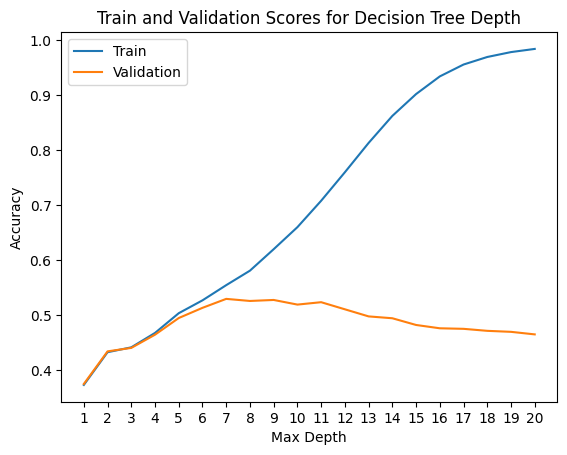

In [50]:
#plot dt depth
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, val_scores, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train and Validation Scores for Decision Tree Depth')
plt.xticks(np.arange(1,21))
plt.legend()
plt.show()

The next hyperparamter I looked at was the minimum number of samples per leaf. Somewhat suprisingly, the best validation performance is set at 1 sample per leaf. My intuition would have suggested that this would lead to more overfitting, but the data suggests otherwise.

In [51]:
#Loop thru min samples leaf and append val and train scores
min_samples_leaf = range(1, 170, 10) # the final value (170) is ~ sqrt of num of samples
train_scores = []
val_scores = []
for leaf in min_samples_leaf:
    dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=leaf,random_state=1)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train_subset, y_train_subset))
    val_scores.append(dt.score(X_val, y_val))
optimal_min_samples_leaf = min_samples_leaf[np.argmax(val_scores)]
print("Optimal min samples split:", optimal_min_samples_leaf)


Optimal min samples split: 1


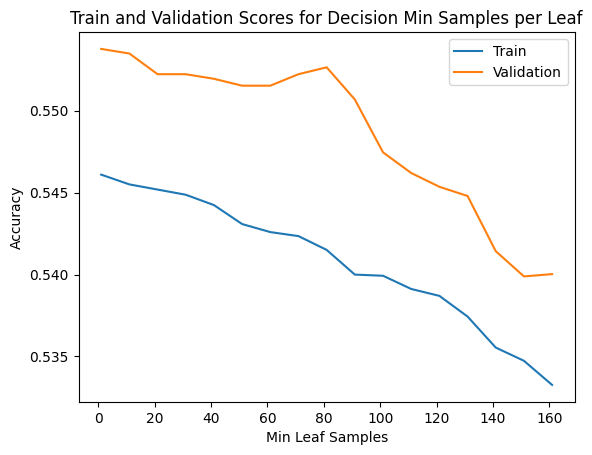

In [52]:
plt.plot(min_samples_leaf, train_scores, label='Train')
plt.plot(min_samples_leaf, val_scores, label='Validation')
plt.xlabel('Min Leaf Samples')
plt.ylabel('Accuracy')
plt.title('Train and Validation Scores for Decision Min Samples per Leaf')

plt.legend()
plt.show()

Finally, I looked at the criterions. These basically determine the quality of a split. The best performance on the validation set was gini, however, they all had a very similar performance.

In [34]:
#loop thru criterions and append train/val
criterions = ['gini', 'entropy', 'log_loss']
train_scores = []
val_scores = []
for criterion in criterions:
    dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=11,random_state=1,criterion=criterion)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    val_scores.append(dt.score(X_val, y_val))
optimal_criterion = criterions[np.argmax(val_scores)]
print("Optimal criterion:", optimal_criterion)


Optimal criterion: gini


The graph below shows the train and validation scores for the three different criterions.

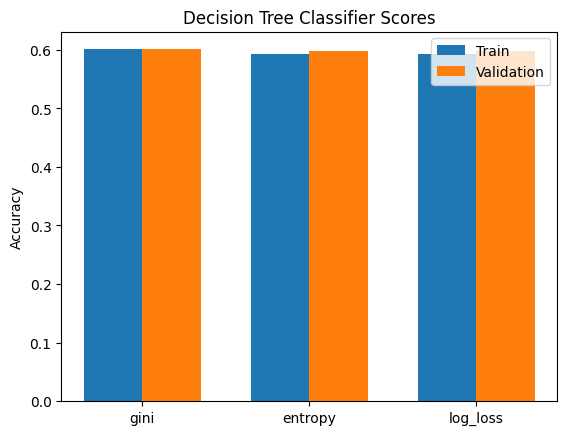

In [35]:
#plot criterions
x = np.arange(len(criterions))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')
ax.set_xticks(x)
ax.set_xticklabels(criterions)
ax.legend()
plt.ylabel('Accuracy')
plt.title('Decision Tree Classifier Scores')
plt.show()

Now that I have my DT optimized, I save my model with `dump`. I built this final model using the optimal hyperparameters I just found. Worth mentioning that I still trained it on only the training subset (not the validation as well). This is because these parameters were optimized with that training data and they could be potentially different if I were to include the validation set as well. 

In [53]:
from joblib import dump 
# decision tree classifier
dt = DecisionTreeClassifier(random_state=1, max_depth=7,min_samples_leaf=11,criterion='gini')
dt.fit(X_train_subset, y_train_subset) #St want to train on the subset of original training data.

dump(dt, 'decision_tree_optimized.joblib') #save the trained model

# Predict on test data
y_pred = dt.predict(X_test)


optimized_dt_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", optimized_dt_accuracy)


optimized_dt_class_report = classification_report(y_test,y_pred,output_dict=True)

Accuracy: 0.5220390309555855


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now I will add this new information from the model into the two success metrics dataframes.

In [55]:
accuracy_df.loc['Decision Tree', 'Optimized Accuracy'] = round(optimized_dt_accuracy,2)


In [56]:
get_class_metrics(optimized_dt_class_report, 'optimized_dt', scores_df)

In [57]:
scores_df

,index,baseline_recall,baseline_f1,baseline_precision,baseline_dt_recall,baseline_dt_f1-score,baseline_dt_precision,optimized_dt_recall,optimized_dt_f1-score,optimized_dt_precision
Genres,,,,,,,,,,
Classical,0,0.025893,0.025846,0.025840,0.500000,0.511628,0.523810,0.538961,0.549669,0.560811
Electronic,1,0.197050,0.197048,0.197078,0.456253,0.456740,0.457228,0.585574,0.513761,0.457638
Experimental,2,0.223475,0.223397,0.223354,0.443062,0.452707,0.462781,0.531297,0.489831,0.454370
Folk,3,0.058978,0.058946,0.058957,0.378031,0.375620,0.373239,0.339515,0.380192,0.431942
Hip-Hop,4,0.074407,0.074338,0.074309,0.384009,0.384442,0.384876,0.289414,0.364023,0.490458
Instrumental,5,0.043921,0.043933,0.043986,0.182692,0.175439,0.168739,0.148077,0.182681,0.238390
International,6,0.029491,0.029453,0.029457,0.256484,0.244505,0.233596,0.077810,0.135678,0.529412
Pop,7,0.048599,0.048621,0.048680,0.097770,0.093137,0.088924,0.000000,0.000000,0.000000
Rock,8,0.297893,0.297935,0.298007,0.651720,0.652640,0.653563,0.750141,0.700922,0.657765


## Random Forest

A random forest is a ML technique that is based on decision trees. It is an ensemble technique that combines many decision trees to create a more robust model. The final prediciton in a rf is made by aggregrating the predictions from all the decision trees through majority vote. Below I run the baseline random forest.

In [47]:
X_train.shape #confirming the shape

(35661, 350)

In [58]:
from sklearn.ensemble import RandomForestClassifier


# Train a random forest classifier
rf = RandomForestClassifier(random_state=1) #set random state for reproducability
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)


baseline_rf_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", baseline_rf_accuracy)


baseline_rf_class_report = classification_report(y_test,y_pred,output_dict=True)

Accuracy: 0.6434219380888291


Add to accuracy_df

In [59]:
accuracy_df.loc['Random Forest', 'Baseline Accuracy'] = round(baseline_rf_accuracy,2)
print("Accuracy:", baseline_rf_accuracy)

Accuracy: 0.6434219380888291


In [60]:
accuracy_df

,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,N/A
Logistic Regression,NaN,NaN
KNN,NaN,NaN
Random Forest,0.64,NaN
Decision Tree,0.47,0.52
Neural Net,NaN,NaN
SMOTE Neural Net,NaN,NaN


In [61]:
get_class_metrics(baseline_rf_class_report, 'baseline_rf', scores_df) #get success metrics

Below I am running a gridsearch on the random forest. A grid search will try every combination of the parameters set in `param_grid`. I add cross validation which helps with the model not overfitting. Through applying cross validation the hope is that the parameters chosen will generalize to new data well.

In [62]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

# pipeline
pipeline = Pipeline([
    ('scaling', None),  
    ('model', RandomForestClassifier(random_state=1))  
])

# parameter grid 
param_grid = {
    'scaling': [None],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15],
    
}

#cross-val
cv = KFold(n_splits=3, shuffle=True, random_state=1)

#Grid Search
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=cv, verbose=3)

# Fit the GridSearchobject on training data
grid_search_rf.fit(X_train, y_train)


 
best_model_rf = grid_search_rf.best_estimator_ #best params
y_pred = best_model_rf.predict(X_test) #predict on x test
score = best_model_rf.score(X_test, y_test) #score
print(f'Best Accuracy: {score}')

#Class report for best model
optimized_rf_class_report = classification_report(y_test,y_pred,output_dict=True)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END model__max_depth=5, model__n_estimators=100, scaling=None;, score=0.530 total time=  12.8s
[CV 2/3] END model__max_depth=5, model__n_estimators=100, scaling=None;, score=0.528 total time=  12.7s
[CV 3/3] END model__max_depth=5, model__n_estimators=100, scaling=None;, score=0.522 total time=  12.8s
[CV 1/3] END model__max_depth=5, model__n_estimators=200, scaling=None;, score=0.529 total time=  25.4s
[CV 2/3] END model__max_depth=5, model__n_estimators=200, scaling=None;, score=0.527 total time=  25.5s
[CV 3/3] END model__max_depth=5, model__n_estimators=200, scaling=None;, score=0.519 total time=  25.4s
[CV 1/3] END model__max_depth=5, model__n_estimators=300, scaling=None;, score=0.530 total time=  38.2s
[CV 2/3] END model__max_depth=5, model__n_estimators=300, scaling=None;, score=0.528 total time=  38.1s
[CV 3/3] END model__max_depth=5, model__n_estimators=300, scaling=None;, score=0.522 total time=  38.1s
[CV 

In [63]:
print(f'Best params: {grid_search_rf.best_params_}')

Best params: {'model__max_depth': 15, 'model__n_estimators': 300, 'scaling': None}


Here I save the best parameters into a fit model and input the success metrics into the dataframes.

In [68]:
rf = RandomForestClassifier(random_state=1,max_depth=15,n_estimators=300)
rf.fit(X_train, y_train)

dump(rf,'random_forest.joblib') #save the trained model

y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print(f'Best Accuracy: {score}')

#Class report for best model
optimized_rf_class_report = classification_report(y_test,y_pred,output_dict=True)

Best Accuracy: 0.6363827549947424


In [69]:
accuracy_df.loc['Random Forest', 'Optimized Accuracy'] = round(score,2)
print(f'Best Accuracy: {score}')

Best Accuracy: 0.6363827549947424


In [70]:
accuracy_df

,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,N/A
Logistic Regression,NaN,NaN
KNN,NaN,NaN
Random Forest,0.64,0.64
Decision Tree,0.47,0.52
Neural Net,NaN,NaN
SMOTE Neural Net,NaN,NaN


In [71]:
get_class_metrics(optimized_rf_class_report, 'optimized_rf', scores_df)

I am displaying the scores for the model often, for one to inspect how each is doing but I do a more robust analysis of these results in notebook 9.

In [72]:
scores_df

,index,baseline_recall,baseline_f1,baseline_precision,baseline_dt_recall,baseline_dt_f1-score,baseline_dt_precision,optimized_dt_recall,optimized_dt_f1-score,optimized_dt_precision,baseline_rf_recall,baseline_rf_f1-score,baseline_rf_precision,optimized_rf_recall,optimized_rf_f1-score,optimized_rf_precision
Genres,,,,,,,,,,,,,,,,
Classical,0,0.025893,0.025846,0.025840,0.500000,0.511628,0.523810,0.538961,0.549669,0.560811,0.711039,0.776596,0.855469,0.678862,0.743875,0.822660
Electronic,1,0.197050,0.197048,0.197078,0.456253,0.456740,0.457228,0.585574,0.513761,0.457638,0.688007,0.633897,0.587678,0.677695,0.632155,0.592351
Experimental,2,0.223475,0.223397,0.223354,0.443062,0.452707,0.462781,0.531297,0.489831,0.454370,0.720211,0.627567,0.556041,0.702168,0.615321,0.547593
Folk,3,0.058978,0.058946,0.058957,0.378031,0.375620,0.373239,0.339515,0.380192,0.431942,0.509272,0.569378,0.645570,0.516934,0.579421,0.659091
Hip-Hop,4,0.074407,0.074338,0.074309,0.384009,0.384442,0.384876,0.289414,0.364023,0.490458,0.502252,0.618157,0.803604,0.481690,0.614555,0.848635
Instrumental,5,0.043921,0.043933,0.043986,0.182692,0.175439,0.168739,0.148077,0.182681,0.238390,0.144231,0.230769,0.576923,0.141827,0.229126,0.595960
International,6,0.029491,0.029453,0.029457,0.256484,0.244505,0.233596,0.077810,0.135678,0.529412,0.216138,0.351288,0.937500,0.208633,0.340176,0.920635
Pop,7,0.048599,0.048621,0.048680,0.097770,0.093137,0.088924,0.000000,0.000000,0.000000,0.010292,0.020134,0.461538,0.006438,0.012685,0.428571
Rock,8,0.297893,0.297935,0.298007,0.651720,0.652640,0.653563,0.750141,0.700922,0.657765,0.831641,0.769070,0.715256,0.836447,0.757300,0.691837


Saving the two dataframes to be accessed in the next notebook.

In [73]:
accuracy_df.to_csv('Data/accuracy_df1.csv')

In [74]:
scores_df.to_csv('Data/scores_df1.csv') 